# 생성적 적대 신경망(Generative adversarial network, GAN)

* 가짜 이미지를 만드는 생성자(Generator)와 진짜 이미지와 가짜 이미지를 구별하는 구별자(Discriminator)로 구성되어 있다.
* 구별자는 진짜와 가짜 판별을 0과 1로 구분하게 된다.
* 이때 생성자는 구별자가 구분 못하는 이미지를 만들도록 해야 하며 구별자는 진위 여부를 잘 가리도록 모델이 만들어져야 한다.

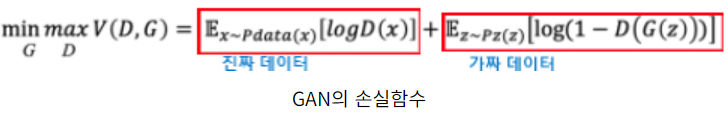

* G는 잠재 변수(latent feature) z로부터 얻어진 가짜 이미지를 의미한다.
* D는 입력값 이미지의 진위 여부를 0과 1 사이로 나타내는 구별자의 결과다.
* 생성자 입장에서는 손실 값이 최소가 되는 방향으로 모델 변수를 업데이트하여 구별자가 구별을 잘 못하도록 한다.
* 구별자는 모델 변수를 손실 함수값이 커지는 방향으로 업데이트하여 구별을 잘 하도록 한다.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
import imageio
import numpy as np
from matplotlib import pyplot as plt

#### 패션 아이템 데이터 불러오기

In [2]:
# transforms.ToTensor()는 PIL 이미지나 Numpy 배열을 PyTorch 텐서로 변환하고,
# transforms.Normalize(0.5,0.5)는 텐서의 모든 값을 평균 0.5, 표준편차 0.5로 정규화한다.
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(0.5,0.5)])
# FashionMNIST 데이터셋을 로드합니다.
# root='./data/'는 데이터를 저장할 디렉토리를 지정하고, train=True는 훈련 데이터셋을 로드하라는 의미이다.
# 만약 데이터셋이 지정한 디렉토리에 없다면 download=True에 의해 자동으로 다운로드된다.
# 마지막으로, 앞서 정의한 transform 객체를 이용하여 데이터를 전처리한다.
trainset = FashionMNIST(root='./data/', train=True, download=True, transform=transform)
# DataLoader는 데이터를 배치 단위로 쪼개고, 학습 시에 데이터를 섞거나 반복시키는 등의 기능을 수행한다.
# batch_size=100은 한 번에 100개의 샘플을 로드하라는 의미이고,
# shuffle=True는 각 에폭(epoch)마다 데이터를 섞어서 모델이 학습 데이터의 순서를 외우는 것을 방지한다.
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 'T-Shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'

100%|██████████| 26421880/26421880 [00:01<00:00, 15540505.63it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 263155.97it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4895192.63it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21336242.09it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



#### 생성자 구축하기

* 여기서는 각각 128차원의 잠재 벡터(n_features)를 입력으로 받고, 784차원의 이미지(n_out)를 출력한다.
* nn.Sequential은 연속된 레이어를 감싸는 모듈로, 레이어를 순서대로 쌓아준다.
* 여기서는 4개의 선형 레이어(nn.Linear)와 각 레이어 사이에 LeakyReLU 활성화 함수를 사용하는 구조를 가진다.
* 마지막으로 nn.Tanh() 활성화 함수로 출력 범위를 -1과 1 사이로 조정한다.
* forward는 신경망의 순전파를 정의하는 함수이다.
* x를 입력으로 받아 self.linear에 통과시킨 후, 출력 벡터를 이미지 형태(28x28)로 변환하여 반환한다.
* view 함수는 텐서의 형태를 변경하는데 사용되며, -1는 나머지 차원을 자동으로 계산하라는 의미이다.

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128
        self.n_out = 784
        self.linear = nn.Sequential(
                    nn.Linear(self.n_features, 256),
                    nn.LeakyReLU(0.2),
                    nn.Linear(256, 512),
                    nn.LeakyReLU(0.2),
                    nn.Linear(512, 1024),
                    nn.LeakyReLU(0.2),
                    nn.Linear(1024, self.n_out),
                    nn.Tanh()
                    )

    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 1, 28, 28)
        return x

#### 구별자 구축하기

* forward 함수에서 x.view()의 인자가 다른 이유는 생성자와 판별자 모델이 처리하는 데이터의 형태와 관련이 있다.

* 생성자(Generator)의 경우, forward 함수에서 x.view(-1, 1, 28, 28)와 같이 설정된 것을 볼 수 있다. 이는 생성자가 784차원의 벡터를 출력하고, 이를 28x28 크기의 2D 이미지로 변환하기 위한 것이다. -1은 배치 크기를 의미하며, 나머지 차원을 자동으로 계산한다.

* 반면, 판별자(Discriminator)는 x.view(-1, 784)와 같이 설정되어 있다. 판별자는 실제 이미지 또는 생성자가 생성한 가짜 이미지를 입력으로 받는다. 이 이미지는 일반적으로 28x28의 2D 형태이므로, 이를 784차원의 1D 벡터로 변환하여 선형 레이어에 입력하기 위해 이런 형태로 설정된다.

* 따라서 x.view()의 인자가 다른 것은 각 모델이 처리하는 데이터의 형태와 그 데이터를 어떻게 처리할지를 결정하기 때문이다.

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_in = 784
        self.n_out = 1
        self.linear = nn.Sequential(
                    nn.Linear(self.n_in, 1024),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3),
                    nn.Linear(1024, 512),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3),
                    nn.Linear(512, 256),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3),
                    nn.Linear(256, self.n_out),
                    nn.Sigmoid()
                    )
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.linear(x)
        return x

#### 생성자와 구별자를 각각 선언한다.

In [5]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

#### 손실 함수 및 최적화 기법 정의하기

In [9]:
pretrained =  False
if pretrained == True:
    discriminator.load_state_dict(torch.load('./models/fmnist_disc.pth'))
    generator.load_state_dict(torch.load('./models/fmnist_gner.pth'))

# 생성자(generator)의 파라미터들을 최적화할 Adam 옵티마이저를 설정한다.
# 여기서 학습률(learning rate)은 0.0002로 설정되어 있다.
g_optim = optim.Adam(generator.parameters(), lr=2e-4)

# 판별자(discriminator)의 파라미터들을 최적화할 Adam 옵티마이저를 설정한다.
# 학습률은 0.0002로 설정되어 있다.
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)

# 각 에폭에서 생성자와 판별자의 손실(loss)을 저장하기 위한 리스트를 초기화한다.
# 이를 통해 학습 과정을 추적하고, 학습이 제대로 이루어지고 있는지 확인할 수 있다.
g_losses = []
d_losses = []
images = []

#  손실 함수(loss function)를 설정한다.
# 여기서는 Binary Cross Entropy(BCE) 손실을 사용한다.
# GAN에서는 판별자가 진짜와 가짜를 얼마나 잘 구별하는지를 판단하는 기준으로 이 손실 함수를 주로 사용한다.
criterion = nn.BCELoss()

#### 잠재 변수 및 라벨 정의하기

###### def noise(n, n_features=128)
* 잠재 공간에서 랜덤한 벡터를 생성하는 함수를 정의한다. 이 벡터는 생성자의 입력으로 사용된다.

###### def label_ones(size) && def label_zeros(size)
* 실제 데이터에 대한 레이블을 1로, 가짜 데이터에 대한 레이블을 0으로 생성하는 함수를 정의한다. 이 레이블은 판별자를 훈련할 때 사용된다.

In [8]:
def noise(n, n_features=128):
    data = torch.randn(n, n_features)
    return data.to(device)

def label_ones(size):
    data = torch.ones(size, 1)
    return data.to(device)

def label_zeros(size):
    data = torch.zeros(size, 1)
    return data.to(device)

#### 구별자 학습 함수 정의하기

In [11]:
# 판별자를 훈련시키는 함수를 정의한다. 이 함수는 옵티마이저, 실제 데이터, 그리고 가짜 데이터를 인자로 받는다.
def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0) # 입력된 실제 데이터의 수를 n으로 저장한다.

    # 옵티마이저의 기울기를 초기화한다.
    # 파이토치에서는 역전파를 진행하기 전에 기울기를 명시적으로 초기화해야한다.
    optimizer.zero_grad()

    # 판별자를 이용하여 실제 데이터에 대한 예측값을 계산한다.
    prediction_real = discriminator(real_data)
    # 실제 데이터에 대한 예측값과 실제 데이터의 레이블(1) 간의 손실을 계산한다.
    d_loss = criterion(prediction_real, label_ones(n))

    # 판별자를 이용하여 가짜 데이터에 대한 예측값을 계산한다.
    prediction_fake = discriminator(fake_data)
    # 가짜 데이터에 대한 예측값과 가짜 데이터의 레이블(0) 간의 손실을 계산한다.
    g_loss = criterion(prediction_fake, label_zeros(n))

    # 실제 데이터에 대한 손실과 가짜 데이터에 대한 손실을 합하여 최종 손실을 계산한다.
    loss = d_loss + g_loss

    # 손실에 대한 역전파를 수행하여 각 파라미터의 기울기를 계산한다.
    loss.backward()
    # 계산된 기울기를 이용하여 옵티마이저를 통해 파라미터를 업데이트한다.
    optimizer.step()

    return loss.item()

#### 생성자 학습 함수 정의하기

In [13]:
def train_generator(optimizer, fake_data):
    # 입력된 가짜 데이터의 수를 n으로 저장한다.
    n = fake_data.size(0)
    # 옵티마이저의 기울기를 초기화한다. 파이토치에서는 역전파를 진행하기 전에 기울기를 명시적으로 초기화해야 한다.
    optimizer.zero_grad()

    # 판별자를 이용하여 가짜 데이터에 대한 예측값을 계산한다.
    prediction = discriminator(fake_data)
    # 가짜 데이터에 대한 예측값과 "진짜"를 의미하는 레이블(1) 간의 손실을 계산한다.
    # 생성자의 목표는 판별자가 생성자가 만든 가짜 데이터를 "진짜"로 분류하도록 만드는 것이므로,
    # 여기에서는 "진짜"를 의미하는 레이블을 사용한다.
    loss = criterion(prediction, label_ones(n))

    # 손실에 대한 역전파를 수행하여 각 파라미터의 기울기를 계산한다.
    loss.backward()
    # 계산된 기울기를 이용하여 옵티마이저를 통해 파라미터를 업데이트한다.
    optimizer.step()

    return loss.item()

#### 모델 학습하기

In [14]:
# 테스트를 위한 노이즈를 생성한다.
# 이 노이즈는 학습 과정 동안 고정되어 있으며, 학습이 진행되는 동안 생성자가 어떻게 변화하는지 확인하기 위해 사용된다.
test_noise = noise(64)
# 훈련 데이터셋의 배치 개수를 l로 저장한다.
l = len(trainloader)

for epoch in range(151):
    g_loss = 0.0
    d_loss = 0.0

    for data in trainloader:
        imgs, _ = data
        n = len(imgs)
        z = noise(n)
        # 실제 이미지(real_data)와 생성자가 생성한 가짜 이미지(fake_data)를 이용하여 판별자를 훈련시킨다.
        fake_data = generator(z).detach()
        real_data = imgs.to(device)
        d_loss += train_discriminator(d_optim, real_data, fake_data)
        # 생성자가 새로 생성한 가짜 이미지(fake_data)를 이용하여 생성자를 훈련시킨다.
        fake_data = generator(z)
        g_loss += train_generator(g_optim, fake_data)

    # 테스트 노이즈를 이용하여 생성자가 만든 이미지를 생성하고, 이를 CPU로 이동시킨다.
    img = generator(test_noise).detach().cpu()
    # 생성된 이미지들을 그리드 형태로 배열한다.
    img = make_grid(img)
    # 생성된 이미지와 각 에폭에서의 생성자와 판별자의 평균 손실을 리스트에 추가한다.
    images.append(img)
    g_losses.append(g_loss/l)
    d_losses.append(d_loss/l)

    # 에폭마다 생성자와 판별자의 평균 손실을 출력한다. 이를 통해 학습 과정을 모니터링할 수 있다.
    if epoch % 10 == 0:
        print('Epoch {}: g_loss: {:.3f} d_loss: {:.3f}\r'.format(epoch, g_loss/l, d_loss/l))

Epoch 0: g_loss: 3.464 d_loss: 0.601
Epoch 10: g_loss: 1.900 d_loss: 0.763
Epoch 20: g_loss: 1.501 d_loss: 0.933
Epoch 30: g_loss: 1.342 d_loss: 0.997
Epoch 40: g_loss: 1.299 d_loss: 1.032
Epoch 50: g_loss: 1.282 d_loss: 1.043
Epoch 60: g_loss: 1.192 d_loss: 1.090
Epoch 70: g_loss: 1.194 d_loss: 1.093
Epoch 80: g_loss: 1.137 d_loss: 1.122
Epoch 90: g_loss: 1.095 d_loss: 1.164
Epoch 100: g_loss: 1.054 d_loss: 1.181
Epoch 110: g_loss: 1.067 d_loss: 1.170
Epoch 120: g_loss: 1.009 d_loss: 1.201
Epoch 130: g_loss: 1.026 d_loss: 1.223
Epoch 140: g_loss: 1.010 d_loss: 1.206
Epoch 150: g_loss: 1.013 d_loss: 1.214


#### 모델 저장하기

In [18]:
torch.save(discriminator.state_dict(), '/models/fmnist_disc.pth')
torch.save(generator.state_dict(), '/models/fmnist_gner.pth')

#### 검증 이미지 변화를 gif 파일로 저장하기

In [19]:
to_image = transforms.ToPILImage()
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('fashion_items_gan.gif', imgs)

#### 손실 함수값 그래프 그리기

##### g_losses가 감소하는 이유
* 생성자는 판별자가 자신이 생성한 가짜 이미지를 진짜로 분류하게 만드는 것이 목표이다. 따라서, g_losses가 감소한다는 것은 생성자가 점점 더 진짜 같은 이미지를 생성하게 되어 판별자를 속이는 능력이 향상되고 있다는 것을 의미한다.

##### d_losses가 증가하는 이유
* 판별자는 생성자가 만든 가짜 이미지와 실제 이미지를 올바르게 구별하는 것이 목표이다. d_losses가 증가한다는 것은 판별자가 가짜 이미지와 진짜 이미지를 구별하는 능력이 점점 떨어지고 있다는 것을 의미한다.


이런 현상은 생성자가 판별자보다 더 빨리 학습하고 있음을 나타낸다. 이는 GAN의 훈련 과정에서 종종 발생하는 현상으로, 이를 해결하기 위한 여러 방법이 연구되고 있다. 예를 들어, 판별자를 더 자주 훈련시키거나, 생성자와 판별자의 학습률을 조절하는 등의 방법이 있다.

다만, 이러한 현상이 반드시 문제가 되는 것은 아니다. 생성자가 판별자를 잘 속일 수 있다면, 그 결과로 나오는 가짜 이미지는 실제 이미지와 매우 유사하게 보일 것이다. 이는 GAN의 주요 목표인 '진짜 같은 가짜 데이터 생성'을 잘 수행하고 있다는 것을 의미한다.



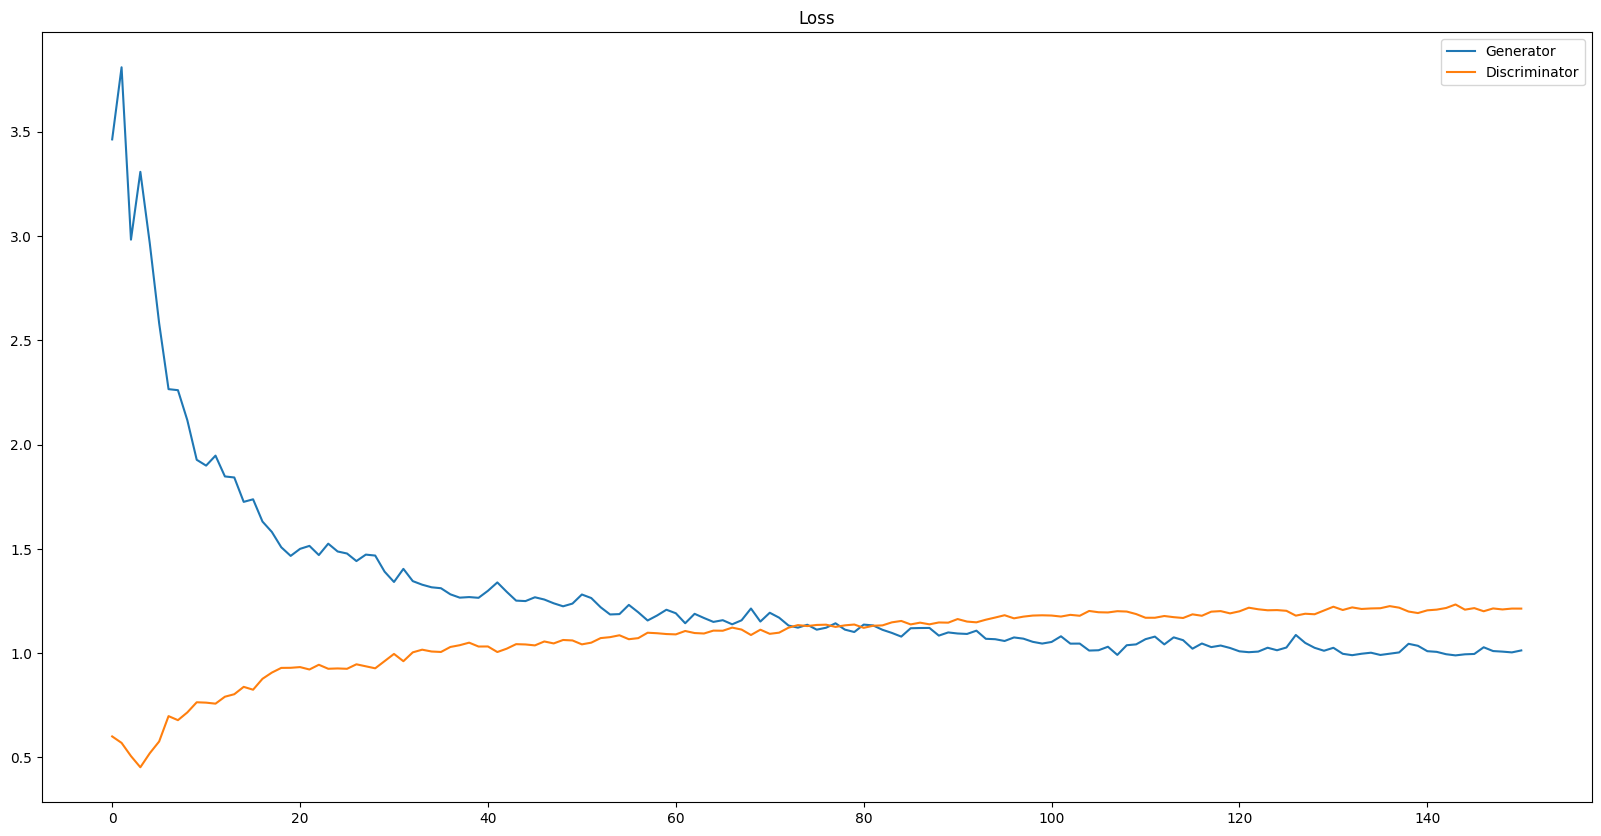

In [20]:
plt.figure(figsize=(20,10))
plt.plot(g_losses)
plt.plot(d_losses)
plt.legend(['Generator','Discriminator'])
plt.title('Loss')
plt.savefig('gan_loss.png')

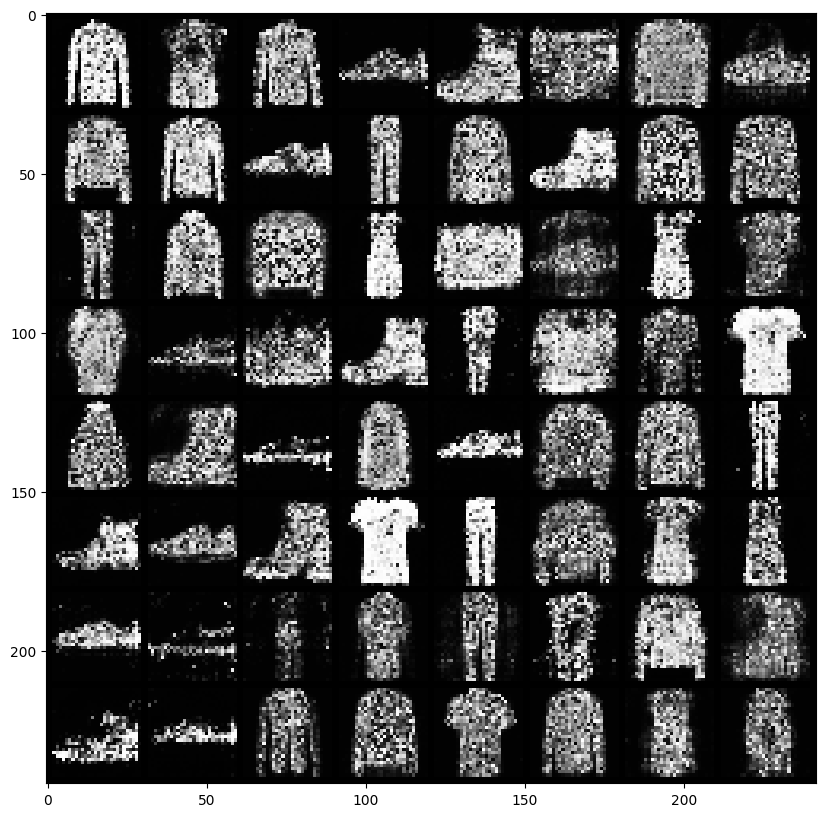

In [21]:
test_noise = noise(64)
to_image = transforms.ToPILImage()
img = generator(test_noise).cpu().detach()
img = to_image(make_grid(img))
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

# Deep Convolutional GAN(DCGAN)

* DCGAN은 GAN 구조를 합성곱 층으로 구성한 모델이다.
* 합성곱 신경망은 다층 퍼셉트론보다 이미지 처리에 매우 유리한 네트워크로 알려져 있다.
* 실제 다층 퍼셉트론으로 구성된 GAN보다 DCGAN을 통해 조금 더 선명한 이미지를 생성할 수 있다.

#### 생성자 구축하기

##### self.conv = nn.Sequential(...)
* 생성자의 구조를 정의한다.
* 여기서는 nn.ConvTranspose2d (역합성곱 레이어)와 nn.ReLU 활성화 함수를 사용하는 네 개의 레이어를 가지며, 마지막으로 nn.Tanh() 활성화 함수로 출력 범위를 [-1, 1]로 조정한다.

##### forward함수
* 신경망의 순전파를 정의하는 함수이다.
* x를 입력으로 받아 잠재 벡터를 이미지 형태로 변환한 후, self.conv에 통과시켜 가짜 이미지를 반환한다.
* view 함수는 텐서의 형태를 변경하는데 사용되며, -1는 나머지 차원을 자동으로 계산하라는 의미이다.

##### nn.ConvTranspose2d 함수의 주요 파라미터들은 다음과 같다.

* in_channels: 입력 텐서의 채널 수를 지정한다. 예를 들어, 흑백 이미지는 채널 수가 1이고, 컬러 이미지는 채널 수가 3이다.
* out_channels: 출력 텐서의 채널 수를 지정한다. 이는 필터(또는 커널)의 수와 같다.
* kernel_size: 커널의 크기를 지정한다. 커널이란 합성곱 연산을 수행하는 윈도우의 크기를 의미한다. 이 파라미터는 하나의 숫자(예: 3) 또는 두 개의 숫자(예: (3, 3))로 지정할 수 있다.
* stride: 커널이 입력 위를 이동하는 간격을 지정한다. stride 값이 크면 출력 텐서의 크기는 작아진다. 이 파라미터를 통해 출력의 크기를 조절할 수 있다.
* padding: 입력의 주변을 0으로 채우는 과정에서 추가하는 0의 행 또는 열의 수를 지정한다. 패딩은 입력 데이터의 공간적 크기를 보존하려는 경우에 사용된다.
* bias: 합성곱 계층에 편향을 추가할지 여부를 지정한다. 기본값은 True이다.
* 따라서 nn.ConvTranspose2d(self.n_features, 256, 3, 1, bias=False) 코드는 입력 채널 수가 self.n_features이고, 출력 채널 수가 256, 커널 크기는 3, 스트라이드는 1이며 편향을 사용하지 않는 역합성곱 레이어를 생성한다.


In [22]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(self.n_features, 256, 3, 1, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 3, 2, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 3, 2, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 2, 2, 1, bias=False),
            nn.Tanh())

    def forward(self, x):
        x = x.view(-1, self.n_features, 1, 1)
        x = self.conv(x)
        return x

#### 구별자 구축하기

In [23]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv =  nn.Sequential(
                    nn.Conv2d(1, 128, 3, 2, 1, bias=False),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.5),
                    nn.Conv2d(128, 256, 3, 2, 1, bias=False),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.5),
                    nn.Conv2d(256, 256, 3, 2, 1, bias=False),
                    nn.LeakyReLU(0.2, inplace=True),
                    nn.Dropout(0.5),
                    nn.Conv2d(256, 1, 3, 2, bias=False),
                    nn.Sigmoid())

    def forward(self, x):
        x = self.conv(x)
        return x.view(-1,1)

#### 손실 함수 및 최적화 방법 정의

In [24]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

pretrained =  False
if pretrained == True:
    discriminator.load_state_dict(torch.load('./models/fmnist_disc_dcgan.pth'))
    generator.load_state_dict(torch.load('./models/fmnist_gner_dcgan.pth'))

g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)

g_losses = []
d_losses = []
images = []

criterion = nn.BCELoss()

def noise(n, n_features=128):
    data = torch.randn(n, n_features)
    return data.to(device)

def label_ones(size):
    data = torch.ones(size, 1)
    return data.to(device)

def label_zeros(size):
    data = torch.zeros(size, 1)
    return data.to(device)

#### 학습 전략 정의

In [25]:
def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0)

    optimizer.zero_grad()

    prediction_real = discriminator(real_data)
    d_loss = criterion(prediction_real, label_ones(n))

    prediction_fake = discriminator(fake_data)
    g_loss = criterion(prediction_fake, label_zeros(n))

    loss = d_loss + g_loss

    loss.backward()
    optimizer.step()

    return loss.item()

def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()

    prediction = discriminator(fake_data)
    loss = criterion(prediction, label_ones(n))

    loss.backward()
    optimizer.step()

    return loss.item()

#### 학습하기

In [ ]:
test_noise = noise(64)
l = len(trainloader)

for epoch in range(301):
    g_loss = 0.0
    d_loss = 0.0

    for data in trainloader:
        imgs, _ = data
        n = len(imgs)
        z = noise(n)
        fake_data = generator(z).detach()
        real_data = imgs.to(device)
        d_loss += train_discriminator(d_optim, real_data, fake_data)
        fake_data = generator(z)
        g_loss += train_generator(g_optim, fake_data)

    img = generator(test_noise).cpu().detach()
    img = make_grid(img)
    images.append(img)
    g_losses.append(g_loss/l)
    d_losses.append(d_loss/l)

    if epoch % 10 == 0:
        print('Epoch {}: g_loss: {:.3f} d_loss: {:.3f}\r'.format(epoch, g_loss/l, d_loss/l))

torch.save(discriminator.state_dict(), '/models/fmnist_disc_dcgan.pth')
torch.save(generator.state_dict(), '/models/fmnist_gner_dcgan.pth')

Epoch 0: g_loss: 0.896 d_loss: 1.271
Epoch 10: g_loss: 0.889 d_loss: 1.274
Epoch 20: g_loss: 0.893 d_loss: 1.276
Epoch 30: g_loss: 0.891 d_loss: 1.272
Epoch 40: g_loss: 0.895 d_loss: 1.279
Epoch 50: g_loss: 0.890 d_loss: 1.274


#### 손실 함수값 그래프 그리기

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(g_losses)
plt.plot(d_losses)
plt.legend(['Generator','Discriminator'])
plt.title('Loss')
plt.savefig('gan_loss.png')